In [53]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import math
import pandas as pd
from scipy.interpolate import interp1d
from scipy import stats
from astropy import units as u
import astroquery
from astroquery.svo_fps import SvoFps
mpl.rcParams['figure.figsize'] = (20, 10) #This changes the size of the output figures. (x,y)
font = {'size'   : 22} #Font size applies to all fonts, axis titles and legend
mpl.rc('font', **font)



def get_a2_int(flux,err,R,T,band):
    B=0
    int_step=1
    for i in range(len(bands)):
        if band==bands[i]:
            wavelength=functions[i]['Wavelength']
            transmission=functions[i]['Transmission']
    if len(wavelength)>200:int_step=int(0.1*len(wavelength))
    for w in range(0,len(wavelength)-1,int_step):    # len-1 for preventing index becoming too big
            B+=transmission[w]*np.pi*R**2/d**2*(2*h*c**2/(wavelength[w]*10**(-8))**5)*\
            1/(np.exp(h*c/(wavelength[w]*10**(-8)*k*T))-1)*(wavelength[w+1]-wavelength[w])*10**(-8)
    a2=((B-flux)/err)**2
   #print(B,flux)
    return a2

def get_a2_bb(flux,err,effective_wavelength,R,T):
    B=np.pi*R**2/d**2*(2*h*c**2/(effective_wavelength*10**(-8))**5)*1/(np.exp(h*c/(effective_wavelength*10**(-8)*k*T))-1)
    if type(flux)==list:
        print(flux)
    a2w=((B-flux)/err)**2
        #print((B-fluxes[i]*1/(effective_width*10**(-8)))**2*1/(err[i]*1/(effective_width*10**(-8)))**2)
    return a2w

    
def interpol(mjd_intp,mjd_old,mag,err):
    first=mjd_old[0]
    last=mjd_old[-1]
    mag_new=[]
    mjd_new=[]
    err_new=[]
    mag_intp=np.interp(mjd_intp,mjd_old,mag)
    err_intp=np.interp(mjd_intp,mjd_old,err)
    for i in range(len(mjd_intp)):
        if mjd_intp[i]<last and mjd_intp[i]>first:
            mjd_new.append(mjd_intp[i])
            mag_new.append(mag_intp[i])
            err_new.append(err_intp[i])
    print('last',mjd_new[-1])
    return(mjd_new,mag_new,err_new)
    
    
def LC(file_name,time_correction,extinction,band,eff_wavelength=False,eff_width=False,zero_point=False,filter_function=False):
    if eff_wavelength==False or eff_width==False and integrate==False: print("ERROR: Either eff_wavelength or eff_width is missing. To integrate set integrate to True")
    mag=[]
    mjd=[]
    error=[]
    last_mjd='.'
    df=pd.read_csv(""+file_name)
    headers=list(df)
    for i in range(len(df.mjd)):
        if pd.notna(df[band][i]): 
            mag.append(df[band][i])
            error.append(df[band+'_er'][i])
            mjd.append(df.mjd[i])
    if interpolate==True:
        arr=interpol(mjd_set,mjd,mag,error)
        mjd=arr[0]
        mag=arr[1]
        err=arr[2]
    if integrate==False:
        for i in range(len(mjd)):
            flux=zero_point * 10**(-0.4 * (mag[i]))*eff_width
            flux_error=(abs(flux*(10**(0.4*error[i])-1)))
            fluxes.append([mjd[i],flux/(eff_width*10**(-8)),flux_error/(eff_width*10**(-8)),eff_wavelength])
            if mjd[i] not in dates:
                    dates.append(mjd[i])
    else:
        for i in range(len(mjd)):
            flux=zero_point * 10**(-0.4 * (mag[i]))
            flux_error=(abs(flux*(10**(0.4*error[i])-1)))
            fluxes.append([mjd[i],flux,flux_error,band])
            if mjd[i] not in dates:
                dates.append(mjd[i])
            if band not in bands:
                bands.append(band)
                functions.append(filter_function)


h=6.626*10**(-27) #erg*s #Constants: Planck, speed of light, Boltzmann, Stefan-Boltzmann
c=2.998*10**10 #cm/s
k=1.381*10**(-16) #erg/K
sb=5.67*10**(-5) #erg/(s*cm^2*K)

###
###
###
###  SET UP THE CODE FOR YOUR DATA
###
###
###

number_of_files=1 #When all your ligth curves are in a single file this is 1
filename="test_lc" #Your light curve file

integrate=False
fluxes=False                    #Magnitudes are assumed as default
interpolate=False               #Interpolate all light curves to same dates
logs=True                       #Having trouble? Enable this and see the output to see what the code is doing.
images=False                     #This will print an image of thw fit to folder called images. 
                                #MAKE SURE TO CREATE THIS FOLDER BEFORE ENABLING

radius_free=True                #Restrict temperature or radius to constant value
temp_free=True                  #When false value select value below

radius_constant=10**10 #cm  #These do nothing unless one of above is false
temp_constant=5700 #K

radius_lower_lim=5*10**9#cm, Iterated through values depend on the object
radius_upper_lim=9*10**10 #cm Computation time is sensitive to these values
radius_step=1*10**9 #cm

temp_lower_lim=4500 #K
temp_upper_lim=6600 #K
temp_step=100 #K
distance_Mpc=10**(-5) #Input here distance in Mpc. 
d=distance_Mpc*3.0857*10**24 # This is conversion from cm to Mpc. No need to touch this.

#Set the epoch if interpolate=True. Default is from -20 to 200 days. Data is not extapolated!

mjd_set=[]
for i in np.arange(-20,200,1):
    mjd_set.append(i)


# INQUIRING FILTER PROFILE SERVICE FOR FILTER FUNCTIONS
# IF INTERGRATE IS FALSE THESE DO NOTHING
functions=[];bands=[] #dont touch

function_u = SvoFps.get_transmission_data('SLOAN/SDSS.uprime_filter')
function_g = SvoFps.get_transmission_data('SLOAN/SDSS.gprime_filter')
function_r = SvoFps.get_transmission_data('SLOAN/SDSS.rprime_filter')
function_i = SvoFps.get_transmission_data('SLOAN/SDSS.iprime_filter')
function_z = SvoFps.get_transmission_data('SLOAN/SDSS.zprime_filter')

# SET UP FILTER PROPERTIES if integrate==True only zeropoints are needed. 
# You can find most filters properties SVO Filter Profile Service
# http://svo2.cab.inta-csic.es/theory/fps/index.php?mode=browse
# Zero points are not needed if fluxes==True
# You need to input these manually. They depend on the telescope, instrument, and filter
# Units should be Ångströms for wavelengths and (erg/cm2/s/Å) for flux

eff_wavelength_u=3608.04
eff_width_u=540.97
zero_point_u=3.75079e-9

eff_wavelength_g=4671.78
eff_width_g=1064.68
zero_point_g=5.45476e-9

eff_wavelength_r=6141.12
eff_width_r=1055.51
zero_point_r=2.49767e-9

eff_wavelength_i=7457.89
eff_width_i=1102.57
zero_point_i=1.38589e-9

eff_wavelength_z=8992.26
eff_width_z=1164.01
zero_point_z=8.38585e-10

# LOADING IN THE DATA. REMOVE/MODIFY THE EXAMPLES TO USE YOUR OWN DATA
fluxes=[] #Dont touch
dates=[]  #Dont touch

LC('test_lc2.csv',0,0,'u',eff_wavelength=eff_wavelength_u,eff_width=eff_width_u,\
   zero_point=zero_point_u,filter_function=function_u)

LC('test_lc2.csv',0,0,'g',eff_wavelength=eff_wavelength_g,eff_width=eff_width_g,\
   zero_point=zero_point_g,filter_function=function_g)

LC('test_lc2.csv',0,0,'r',eff_wavelength=eff_wavelength_r,eff_width=eff_width_r,\
   zero_point=zero_point_r,filter_function=function_r)

LC('test_lc2.csv',0,0,'i',eff_wavelength=eff_wavelength_i,eff_width=eff_width_i,\
   zero_point=zero_point_i,filter_function=function_i)

LC('test_lc2.csv',0,0,'z',eff_wavelength=eff_wavelength_z,eff_width=eff_width_z,\
   zero_point=zero_point_z,filter_function=function_z)

#print(fluxes)

## SET UP ENDS
## The rest of the code ##
##


Temperatures=[]
Radii=[]
dates_bol=[]
khi2s=[]
N_d=[]
index=0
T_lista=[]
R_lista=[]
Radii_low=[]
Radii_up=[]
Temp_low=[]
Temp_up=[]
index=0
if radius_free==True and temp_free==True:free_param=2
else:free_param=1
if radius_free==False:radius_lower_lim=radius_constant;radius_upper_lim=radius_constant+1;radius_step=radius_constant
if temp_free==False:temp_lower_lim=temp_constant;temp_upper_lim=temp_constant+1;temp_step=temp_constant
if integrate==True:images=False #They are not compatible
for date in dates:
    min_khi2=10000000000000000000000000000
    T_list=[]
    R_list=[]
    T_llim=10**10
    T_ulim=0
    R_llim=10**20
    R_ulim=0
    one_sig=False
    for R in range(radius_lower_lim,radius_upper_lim,radius_step):    # Interval low, interval high, step (large step for low computation)
        for T in range(temp_lower_lim,temp_upper_lim,temp_step):
            if integrate==True:
                a2=[]             
                for array in fluxes:
                    if array[0]==date:
                        a2.append(get_a2_int(array[1],array[2],R,T,array[3]))
            else:
                for_images=[]
                a2=[]
                for array in fluxes:
                    if array[0]==date:
                        a2.append(get_a2_bb(array[1],array[2],array[3],R,T))
                        for_images.append(array)
            if len(a2)<3:
                print('breaking')
                break
            khi2=sum(a2)/len(a2)
            T_list.append([T,khi2])
            R_list.append([R,khi2])
            if sum(a2)/len(a2)<min_khi2:
                min_khi2=khi2
                T_min=T
                R_min=R
                if images==True:used_fluxes=for_images
    if len(a2)>2:
        if T_min<(temp_lower_lim+temp_step*1.1) or T_min>(temp_upper_lim-temp_step*1.1):
            print('ALARM! Too narrow limit at day:',date, T_min,' K')
        if R_min<(radius_lower_lim+radius_step*1.1) or R_min>(radius_upper_lim+radius_step*1.1):
            print('ALARM! Too narrow limit at day:',date, R_min/10**14,'*10^14 cm,')
        Radii.append(R_min)
        Temperatures.append(T_min)
        dates_bol.append(date)
        khi2s.append(khi2)
        N_d.append(len(a2))
        for i in range(len(T_list)):
            if abs(0.6827>stats.chi2.cdf(T_list[i][1], len(a2)-free_param)):
                one_sig=True
                if T_list[i][0]<T_llim:
                    T_llim=T_list[i][0]
                if T_list[i][0]>T_ulim:
                    T_ulim=T_list[i][0]
                if R_list[i][0]>R_ulim:
                    R_ulim=R_list[i][0]
                if R_list[i][0]<R_llim:
                    R_llim=R_list[i][0]
        if one_sig==True:
            Radii_low.append(R_llim)
            Radii_up.append(R_ulim)
            Temp_low.append(T_llim)
            Temp_up.append(T_ulim) 
        else:
            print('khi-square not in 68 confidence interval, i.e., error too large')
            Radii_low.append(R_min)
            Radii_up.append(R_min)
            Temp_low.append(T_min)
            Temp_up.append(T_min)
        if logs==True:
            print('Tmin', T_min,'K Rmin',R_min/10**14,'*10^14 cm,','number of bands',len(a2))
        #if date ==-10:   #Redundant
        #   print(sum(f_g)/len(f_g),sum(f_r)/len(f_r),sum(f_i)/len(f_i),sum(f_o)/len(f_o),sum(f_c)/len(f_c))
        if images==True:
            wl=np.linspace(3000,10000,500)
            B_min=np.pi*R_min**2/d**2*(2*h*c**2/(wl*10**(-8))**5)*1/(np.exp(h*c/(wl*10**(-8)*k*T_min))-1)
            plt.ioff()
            fig, ax = plt.subplots()
            font = {'size'   : 21}
            mpl.rc('font', **font)
            plt.plot(wl,B_min)
            for j in used_fluxes:
                plt.errorbar(j[3],j[1],j[2],color='green',fmt="o",capsize=3)
            ax.set_ylabel('Flux intensity [erg]$\cdot$s$^-1$ $\cdot $cm$^-2$ Å$^-1$]', fontsize=22)
            ax.set_xlabel('Wavelength [Å]',fontsize=22)
            plt.savefig('ims/'+str(date)+'.png')
            plt.clf()
            plt.close(fig)
#print(c,h,sb,k) # Checking that I didn't re-assign anything accidentally, cgs units
#print(khi2s)
Luminosities=[]
Lum_low=[]
Lum_up=[]
for i in range(len(dates_bol)):
    Luminosities.append(4*np.pi*Radii[i]**2*sb*Temperatures[i]**4)
    Lum_low.append(4*np.pi*Radii_low[i]**2*sb*Temp_low[i]**4)
    Lum_up.append(4*np.pi*Radii_up[i]**2*sb*Temp_up[i]**4)

#CREATING THE OUTPUT FILE
f = open("Results.txt", "w")
f.write('Day,L,L_l,L_u,T,T_l,T_u,R,R_l,R_u,khi2\n')
for i in range(len(dates_bol)):
    f.write(''+str(dates_bol[i])+','+str(np.log10(Luminosities[i]))+','+str(np.log10(Lum_low[i]))+','+str(np.log10(Lum_up[i]))+','+str(Temperatures[i])+','+str(Temp_low[i])+str(Temp_up[i])+','+str(Radii[i])+','+str(Radii_low[i])+','+str(Radii_up[i])+','+str(khi2s[i])+'\n')
f.close()

number of loops 1785.0
Tmin 6000 K Rmin 0.00064 *10^14 cm, number of bands 5
Tmin 5500 K Rmin 0.00073 *10^14 cm, number of bands 5
Tmin 5300 K Rmin 0.00087 *10^14 cm, number of bands 5
Tmin 5500 K Rmin 0.00075 *10^14 cm, number of bands 4
Tmin 5500 K Rmin 0.00075 *10^14 cm, number of bands 5
khi-square not in 68 confidence interval, i.e., error too large
Tmin 5900 K Rmin 0.00067 *10^14 cm, number of bands 5
Tmin 6100 K Rmin 0.00062 *10^14 cm, number of bands 5


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0.00089
0.00056
lens 7 7


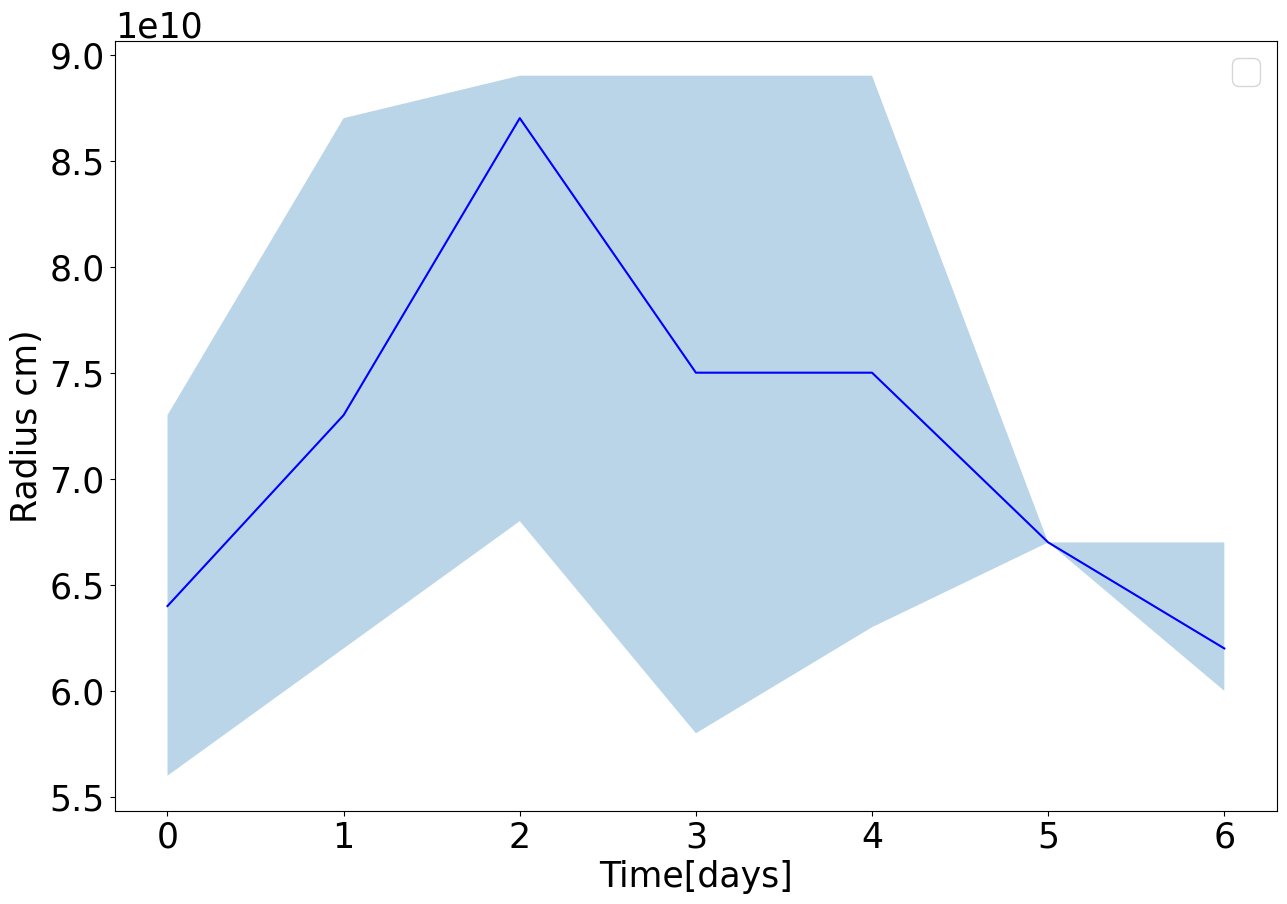

In [52]:
print(max(Radii_up)/(10**14))
print(min(Radii_low)/(10**14))
print('lens',len(Radii_up),len(Radii_low))
#print(R_lista)
#print(Radii_up)
#print(Radii_low)


fig, ax = plt.subplots()
font = {'size'   : 25}
mpl.rc('font', **font)

ax = plt.gca()
#ax.set_xlim(-12, 415)
ax.set_ylabel("Radius cm)")
ax.set_xlabel("Time[days]")
#ax.set_ylim(0.01*10**15, 4.5*10**15)
plt.legend(loc='best')

ax.fill_between(dates_bol, Radii_low,Radii_up,alpha=0.3)
ax.plot(dates_bol,Radii,color='b')

#plt.errorbar(dates_bol,Radii,label='rad',yerr=R_err,fmt='o',color='b',capsize=3)

#plt.plot(dates_bol,Radii)

mpl.rcParams['figure.figsize'] = (15, 10)
plt.show()
fig.savefig("Radius.png")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


6400
5000


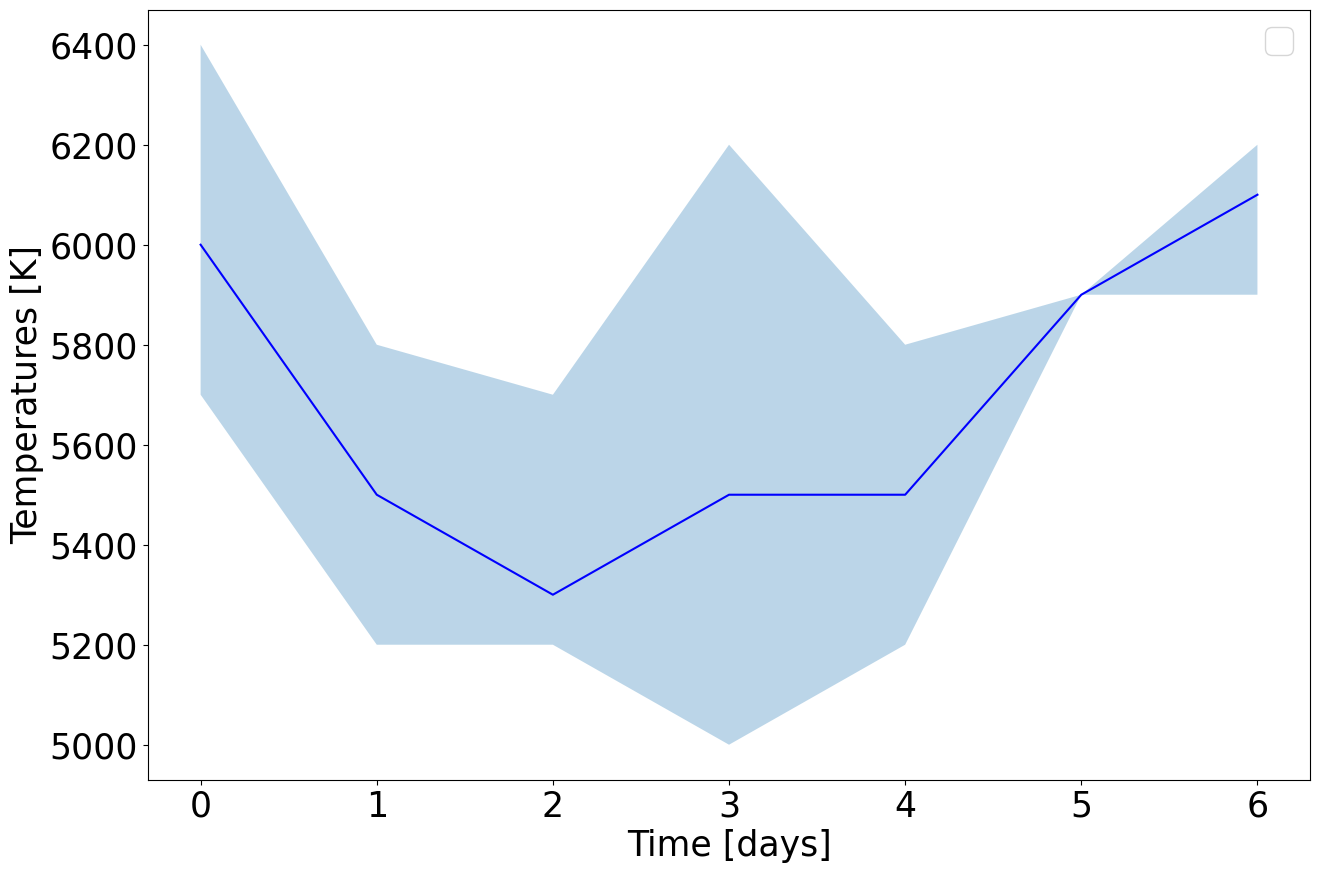

In [49]:
print(max(Temp_up))
print(min(Temp_low))
fig, ax = plt.subplots()
font = {'size'   : 25}
mpl.rc('font', **font)

ax = plt.gca()
#ax.set_ylim(5000, 6000)
#ax.set_xlim(-12, 415)
ax.set_ylabel("Temperatures [K]")
ax.set_xlabel("Time [days]")
plt.legend(loc='best')

ax.fill_between(dates_bol, Temp_low,Temp_up,alpha=0.3)
ax.plot(dates_bol,Temperatures,color='b')

#plt.errorbar(dates_bol,Radii,label='rad',yerr=T_err,fmt='o',color='b',capsize=3)
#plt.plot(dates_bol,Radii)

mpl.rcParams['figure.figsize'] = (15, 10)
plt.show()
fig.savefig("Temp.png")

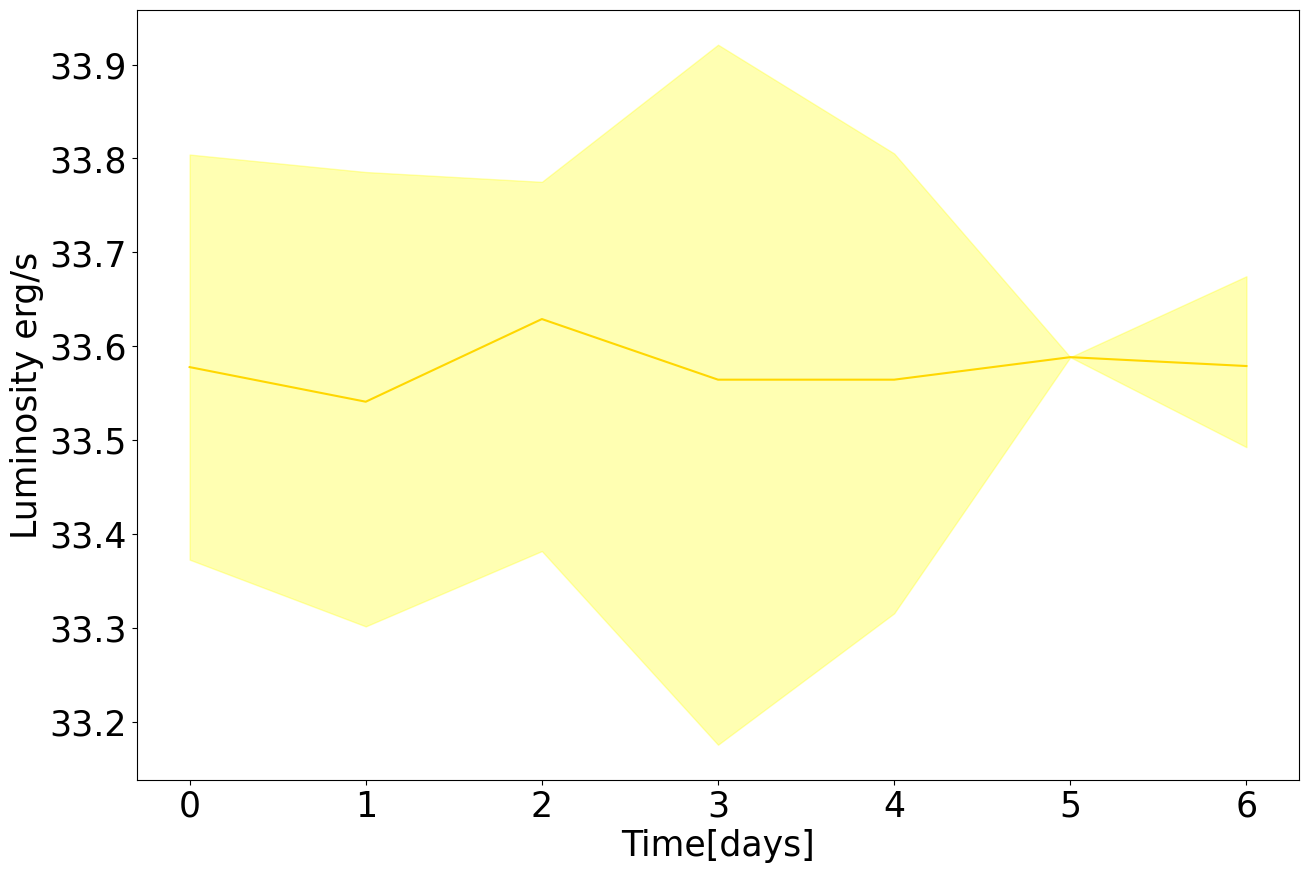

In [50]:
#BOLOMETRIC LUMINOSITY
fig, ax = plt.subplots()
font = {'size'   : 25}
mpl.rc('font', **font)

ax = plt.gca()
#ax.set_xlim(-12, 415)
#ax.set_ylim(41.2, 42.55)
ax.set_ylabel("Luminosity erg/s")
ax.set_xlabel("Time[days]")

  
ax.fill_between(dates_bol, np.log10(Lum_low),np.log10(Lum_up),color='yellow',alpha=0.3)
ax.plot(dates_bol,np.log10(Luminosities),color='gold')
    
mpl.rcParams['figure.figsize'] = (15, 10)
plt.show()
fig.savefig("Luminosity.png")